<a href="https://colab.research.google.com/github/cebisiles/unsupervised-predict-streamlit-template/blob/master/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

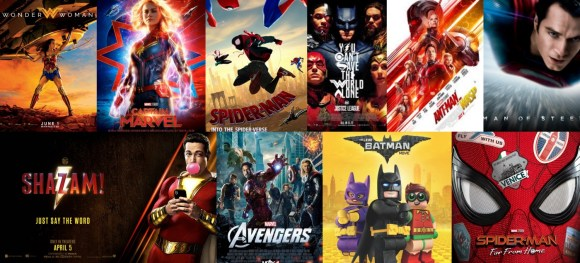

![](https://drive.google.com/file/d/1SUNSVcQYfGPeJ0uv51x9-EyIsgg--tx9/view?usp=sharing)

## **Project Overview and Description**

**“Every time I go to a movie, it’s magic, no matter what the movie’s about.” –  Steven Spielberg**

Everyone loves movies irrespective of age, gender, race, color, or geographical location. We all in a way are connected to each other via this amazing medium. Yet what most interesting is the fact that how unique our choices and combinations are in terms of movie preferences. Some people like genre-specific movies be it a thriller, romance, or sci-fi, while others focus on lead actors and directors. When we take all that into account, it’s astoundingly difficult to generalize a movie and say that everyone would like it. But with all that said, it is still seen that similar movies are liked by a specific part of the society.

This report was prepared by The DreamTeam on 02 Febuary 2022

Table of Contents
1. Starting a Comet Experiment

2. Importing Packages

3. Loading Data

  3.1 Data Merging

4. Data Processing and Engineering

  4.1 Checking null values

5. Exploratory Data Analysis (EDA)

6. Modeling

  6.1 Normal Predictor

  6.2 Singular Value Decomposition(SVD)

  6.3 Singular Value Decomposition plus plus(SVD++)

  6.4 Non-negative Matrix Factorization(NMF)

  6.5 Baseline Only

  6.6 CoClustering

  6.7 KNN with Means


7. Model Performance
8.Model Submission
9.Conclusion
10. Comet session closing

# **1. Starting a Comet Experiment**

In [ ]:
!pip install comet_ml


In [ ]:
# import comet_ml at the top of your file
from comet_ml import Experiment

# Create an experiment with your api key
experiment = Experiment(
    api_key="qPSB4ail2BLvJOkpLaqwE6FSe",
    project_name="unsupervised-learning",
    workspace="cebisiles",
)

# **2. Importing Libraries**

In [ ]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split

# **3. Loading Data**

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

The functions below they load the data and merge it based on the movie ID, simultanously, thus to save time other than indivisually doing it

In [ ]:
def load(s):
    l=[]
    for i in s:
        l+=[pd.read_csv("/kaggle/input/edsa-movie-recommendation-wilderness/"+i+".csv")]
    return l

In [ ]:
def merge_movie_id(s):
    p=s[0]
    d=s[1:]
    for i in d:
        p=p.merge(i,how='left',on='movieId')
    return p

In [ ]:
train_df=merge_movie_id(load(['train','movies'])[:4])
test_df=merge_movie_id(load(['test','movies'])[:4])

Thus from here we will consider the train df 

In [ ]:
df=train_df

Then we look at the five number summary of the Ratings as well as the standard deviation 

In [ ]:
df['rating'].describe()

From this we can see that the minimun rating for the data is 0.5

# **4. Data Preprocessing**

### Checking null values

In [ ]:
df.isna().sum()

# **5. Exploratory Data Analysis (EDA)**

## Ratings Distribution

In [ ]:
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

data = df['rating'].value_counts().sort_index(ascending=False)
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / df.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               )
# Create layout
layout = dict(title = 'Distribution Of {} ratings'.format(df.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

We can see that less than 13% of all ratings in the data have a rating of less or equal to 2, and low movies movie mean they are generally really bad.

## Rating Distribution per Movie

In [ ]:
# Number of ratings per book
data = df.groupby('movieId')['rating'].count().clip(upper=50)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per Movie (Clipped at 50)',
                   xaxis = dict(title = 'Number of Ratings Per Movie'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [ ]:
df.groupby('movieId')['rating'].count().reset_index().sort_values('rating', ascending=False)[:10]

## Ratings Distribution By User

In [ ]:
# Number of ratings per user
data = df.groupby('userId')['rating'].count().clip(upper=50)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per User (Clipped at 50)',
                   xaxis = dict(title = 'Ratings Per User'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [ ]:
df.groupby('userId')['rating'].count().reset_index().sort_values('rating', ascending=False)[:10]


In [ ]:
min_movie_ratings = 2
filter_movies = df['rating'].value_counts() > min_movie_ratings
filter_movies = filter_movies[filter_movies].index.tolist()

min_user_ratings = 50
filter_users = df['userId'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

df_new = df[(df['rating'].isin(filter_movies)) & (df['userId'].isin(filter_users))]
print('The original data frame shape:\t{}'.format(df.shape))
print('The new data frame shape:\t{}'.format(df_new.shape))

# **6. Modeling**

## **Modelling with Surprise**

To load a dataset from a pandas dataframe, we will use the load_from_df() method, we will also need a Reader object, and the rating_scale parameter must be specified. The dataframe must have three columns, corresponding to the user ids, the movie ids, and the ratings in this order. Each row thus corresponds to a given rating.

In [ ]:
df = df_new.sample(50000)
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

With the Surprise library, we will benchmark the following algorithms

# ****Basic algorithms****

## **NormalPredictor**

NormalPredictor algorithm predicts a random rating based on the distribution of the training set, which is assumed to be normal. This is one of the most basic algorithms that do not do much work.

## **BaselineOnly**

BasiclineOnly algorithm predicts the baseline estimate for given user and item.
# **k-NN algorithms**
## **KNNBasic**
KNNBasic is a basic collaborative filtering algorithm.
## **KNNWithMeans**
KNNWithMeans is basic collaborative filtering algorithm, taking into account the mean ratings of each user.
## **KNNWithZScore**
KNNWithZScore is a basic collaborative filtering algorithm, taking into account the z-score normalization of each user.
## **KNNBaseline**
KNNBaseline is a basic collaborative filtering algorithm taking into account a baseline rating.

# **Matrix Factorization-based algorithms**
## **SVD**
SVD algorithm is equivalent to Probabilistic Matrix Factorization (http://papers.nips.cc/paper/3208-probabilistic-matrix-factorization.pdf)

## **SVDpp**
The SVDpp algorithm is an extension of SVD that takes into account implicit ratings.

## **NMF**
NMF is a collaborative filtering algorithm based on Non-negative Matrix Factorization. It is very similar with SVD.

## **Slope One**
Slope One is a straightforward implementation of the SlopeOne algorithm. (https://arxiv.org/abs/cs/0702144)

## **Co-clustering**
Co-clustering is a collaborative filtering algorithm based on co-clustering (http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.113.6458&rep=rep1&type=pdf)

KNNWithMeans(),, NormalPredictor(), KNNBaseline(), KNNBasic(),  KNNWithZScore(),

In [ ]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), KNNWithMeans(), SlopeOne(), NMF(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)

# **7. Model Performance**

## We use RMSE as our accuracy metric for the predictions

In [ ]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

In [ ]:
surprise_results

*SVDpp* algorithm gave us the best rmse, therefore, we will proceed further with *SVDpp* and use **Root Mean Square Error(RMSE)**.

In [ ]:
print('Using ALS')
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }
algo = SVDpp()
cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)

In [ ]:
trainset, testset = train_test_split(data, test_size=0.25)
algo = SVDpp()
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

In [ ]:
trainset = algo.trainset
print(algo.__class__.__name__)

### To inspect our predictions in details, we are going to build a pandas data frame with all the predictions.

In [ ]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)

In [ ]:
df.head()

In [ ]:
best_predictions = df.sort_values(by='err')[:10]
worst_predictions = df.sort_values(by='err')[-10:]

In [ ]:
best_predictions

In [ ]:
worst_predictions

### The worst predictions look pretty surprise. Let's look in more details of the last one movieID 79132, the movie was rated by 33 users, user "136170" rated 0.5, our SVDpp algorithm predicts 4,1.

In [ ]:
from surprise.model_selection import GridSearchCV

param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
gs = GridSearchCV(algo, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

# **8. Model Submission**

In [ ]:
l=[]
for index, row in test_df.iterrows():
    l+=[algo.predict(row['userId'], row['movieId']).est]

In [ ]:
sub=pd.read_csv("/kaggle/input/edsa-movie-recommendation-wilderness/sample_submission.csv")

In [ ]:
sub['rating']=l

In [ ]:
sub.to_csv("submission.csv",index=False)

# **9. Conclusion**

A **collaborative filtering** approach is taken to
implement the system. This approach overcomes drawbacks of each individual algorithm and
improves the performance of the system. Techniques like Clustering, Similarity and
Classification are used to get better recommendations thus reducing RMSE and increasing
precision and accuracy. In future we can work on collaborative recommender using clustering and
similarity for better performance. 

Our approach can be further extended to other domains to
recommend songs, video, venue, news, books, tourism and e-commerce sites, etc

# **10. Comet session closing**

In [ ]:
experiment.end()